# Scraping News Articles for Data Retrieval

We will be scrapping inshorts, a news website, with the use of popular python NLP  libraries: SpaCY and nltk. For this project, we our focus will mainly be on technology, sports and world affairs articles.

In [1]:
# ! pip install nltk
# ! pip install graphviz
# ! pip install -U textblob
# ! pip install -U pip setuptools wheel
# ! pip install -U spacy
# ! python -m spacy download en_core_web_sm

In [41]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from nltk.corpus import conll2000
from IPython.display import display
from nltk.parse.stanford import StanfordParser
from nltk.parse.corenlp import CoreNLPParser
from spacy import displacy
from nltk.parse.stanford import StanfordDependencyParser
from nltk.tag import StanfordNERTagger
data = conll2000.chunked_sents()
import spacy
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.chunk.util import tree2conlltags, conlltags2tree
from nltk.tag import UnigramTagger, BigramTagger
from nltk.chunk import ChunkParserI
import re
from bs4 import BeautifulSoup
from contractions import CONTRACTION_MAP
import unicodedata
from nltk.corpus import stopwords
from graphviz import Source


%matplotlib inline

#nltk.download('stopwords')
#nltk.download('conll2000')
#nltk.download('averaged_perceptron_tagger')

In [3]:
seed_urls = ['https://inshorts.com/en/read/technology',
             'https://inshorts.com/en/read/sports',
             'https://inshorts.com/en/read/world']

In [4]:
def build_dataset(seed_urls):
    news_data = []
    for url in seed_urls:
        news_category = url.split('/')[-1]
        data = requests.get(url)
        soup = BeautifulSoup(data.content, 'html.parser')
        
        news_articles = [{'news_headline': headline.find('span', 
                                                         attrs={"itemprop": "headline"}).string,
                          'news_article': article.find('div', 
                                                       attrs={"itemprop": "articleBody"}).string,
                          'news_category': news_category}
                         
                            for headline, article in 
                             zip(soup.find_all('div', 
                                               class_=["news-card-title news-right-box"]),
                                 soup.find_all('div', 
                                               class_=["news-card-content news-right-box"]))
                        ]
        news_data.extend(news_articles)
        
    df =  pd.DataFrame(news_data)
    df = df[['news_headline', 'news_article', 'news_category']]
    return df

In [5]:
news_df = build_dataset(seed_urls)
news_df.head(10)

,news_headline,news_article,news_category
0,'Bachpan Ka Pyaar' fame Sahdev Dirdo to launch...,'Bachpan Ka Pyaar' fame Sahdev Dirdo is set to...,technology
1,Firefox browser failing to load websites for s...,Several users of Firefox browser complained on...,technology
2,Govt says Tesla trying to pressurise India aft...,"After Elon Musk said he's working through ""a l...",technology
3,'Baby Shark' becomes the first video to cross ...,Pinkfong's 'Baby Shark Dance' has become the f...,technology
4,Dark web's largest stolen credit cards seller ...,Dark web's largest vendor of stolen credit car...,technology
5,Sundar Pichai shares concept pics of UK office...,Google CEO Sundar Pichai said that he's excite...,technology
6,"TCS, Wipro, Infosys added record 1.7 lakh empl...","IT companies TCS, Infosys and Wipro added a re...",technology
7,Pakistan planning a complete ban on cryptocurr...,The Pakistan government and the State Bank of ...,technology
8,"Tech workers being offered $10,000 in bitcoin,...","A non-profit council is offering $10,000 in bi...",technology
9,Dogecoin jumps 20% as Elon Musk says Tesla mer...,Dogecoin jumped around 20% after Tesla CEO Elo...,technology


In [6]:
news_df.news_category.value_counts()

technology    25
sports        25
world         24
Name: news_category, dtype: int64

In [7]:
nlp = spacy.load("en_core_web_sm")
tokenizer = ToktokTokenizer()
stopword_list = set(stopwords.words('english'))
stopword_list.remove('no')
stopword_list.remove('not')

## Removing html tags

In [8]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text

In [9]:
strip_html_tags('<html><h2>The boy who lived...come to die</h2></html>')

'The boy who lived...come to die'

## Removing accented characters

In [10]:
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

In [11]:
remove_accented_chars('Sómě Áccěntěd těxt')

'Some Accented text'

In [12]:
def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [13]:
expand_contractions("Y'all can't expand contractions I'd think")

'You all cannot expand contractions I would think'

In [14]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', text)
    return text

In [15]:
remove_special_characters("Well this was fun! What do you think? 123#@!", 
                          remove_digits=True)

'Well this was fun What do you think '

## Stemming

In [16]:
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

In [17]:
simple_stemmer("My system keeps crashing his crashed yesterday, ours crashes daily")

'my system keep crash hi crash yesterday, our crash daili'

## Lemmatization

In [18]:
 def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text


In [19]:
lemmatize_text("My system keeps crashing! his crashed yesterday, ours crashes daily")

'my system keep crash ! his crash yesterday , ours crash daily'

## Removing Stopwords

In [20]:
def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text


In [21]:
remove_stopwords("The, and, if are stopwords, computer is not")

', , stopwords , computer not'

## Text Normalizer

In [22]:
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_digits=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters and\or digits    
        if special_char_removal:
            # insert spaces between special characters to isolate them    
            special_char_pattern = re.compile(r'([{.(-)!}])')
            doc = special_char_pattern.sub(" \\1 ", doc)
            doc = remove_special_characters(doc, remove_digits=remove_digits)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

## Pre-process and normalize news articles

In [23]:
news_df['full_text'] = news_df["news_headline"].map(str)+'. '+news_df["news_article"]

In [24]:
news_df['clean_text'] = normalize_corpus(news_df['full_text'])
norm_corpus = list(news_df['clean_text'])
news_df.iloc[1][['full_text', 'clean_text']].to_dict()

{'full_text': 'Firefox browser failing to load websites for several users worldwide. Several users of Firefox browser complained on Twitter on Thursday that the browser wasn\'t working and they were unable to load websites. An online forum said the issue appeared to be an infinite loop bug in Firefox\'s HTTP3 implementation, with one user suggesting a workaround. "Open \'about:config\' in a new tab. Search : \'network.http.http3.enabled\' change to false...then restart," they suggested.',
 'clean_text': 'firefox browser fail load website several user worldwide several user firefox browser complain twitter thursday browser not work unable load website online forum say issue appear infinite loop bug firefoxs http implementation one user suggest workaround open config new tab search network http http enable change false restart suggest'}

## Saving news articles to csv

In [25]:
news_df.to_csv('news.csv', index=False, encoding='utf-8')

## Tagging Parts of Speech

In [26]:
corpus = normalize_corpus(news_df['full_text'], text_lower_case=False, 
                          text_lemmatization=False, special_char_removal=False)

sentence = str(news_df.iloc[1].news_headline)
sentence_nlp = nlp(sentence)

In [27]:
# POS tagging with spacy
spacy_pos_tagged = [(word, word.tag_, word.pos_) for word in sentence_nlp]
pd.DataFrame(spacy_pos_tagged, columns=['Word', 'POS tag', 'Tag type'])

,Word,POS tag,Tag type
0,Firefox,JJ,ADJ
1,browser,NN,NOUN
2,failing,VBG,VERB
3,to,TO,PART
4,load,VB,VERB
5,websites,NNS,NOUN
6,for,IN,ADP
7,several,JJ,ADJ
8,users,NNS,NOUN
9,worldwide,RB,ADV


In [28]:
# POS tagging with NLTK
nltk_pos_tagged = nltk.pos_tag(sentence.split())
pd.DataFrame(nltk_pos_tagged, columns=['Word', 'POS tag'])

,Word,POS tag
0,Firefox,NNP
1,browser,NN
2,failing,VBG
3,to,TO
4,load,VB
5,websites,NNS
6,for,IN
7,several,JJ
8,users,NNS
9,worldwide,VBP


In [29]:
train_data = data[:10900]
test_data = data[10900:] 

print(len(train_data), len(test_data))
print(train_data[1]) 

10900 48
(S
  Chancellor/NNP
  (PP of/IN)
  (NP the/DT Exchequer/NNP)
  (NP Nigel/NNP Lawson/NNP)
  (NP 's/POS restated/VBN commitment/NN)
  (PP to/TO)
  (NP a/DT firm/NN monetary/JJ policy/NN)
  (VP has/VBZ helped/VBN to/TO prevent/VB)
  (NP a/DT freefall/NN)
  (PP in/IN)
  (NP sterling/NN)
  (PP over/IN)
  (NP the/DT past/JJ week/NN)
  ./.)


In [30]:
wtc = tree2conlltags(train_data[1])
wtc

[('Chancellor', 'NNP', 'O'),
 ('of', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('Exchequer', 'NNP', 'I-NP'),
 ('Nigel', 'NNP', 'B-NP'),
 ('Lawson', 'NNP', 'I-NP'),
 ("'s", 'POS', 'B-NP'),
 ('restated', 'VBN', 'I-NP'),
 ('commitment', 'NN', 'I-NP'),
 ('to', 'TO', 'B-PP'),
 ('a', 'DT', 'B-NP'),
 ('firm', 'NN', 'I-NP'),
 ('monetary', 'JJ', 'I-NP'),
 ('policy', 'NN', 'I-NP'),
 ('has', 'VBZ', 'B-VP'),
 ('helped', 'VBN', 'I-VP'),
 ('to', 'TO', 'I-VP'),
 ('prevent', 'VB', 'I-VP'),
 ('a', 'DT', 'B-NP'),
 ('freefall', 'NN', 'I-NP'),
 ('in', 'IN', 'B-PP'),
 ('sterling', 'NN', 'B-NP'),
 ('over', 'IN', 'B-PP'),
 ('the', 'DT', 'B-NP'),
 ('past', 'JJ', 'I-NP'),
 ('week', 'NN', 'I-NP'),
 ('.', '.', 'O')]

In [31]:
def conll_tag_chunks(chunk_sents):
    tagged_sents = [tree2conlltags(tree) for tree in chunk_sents]
    return [[(t, c) for (w, t, c) in sent] for sent in tagged_sents]


def combined_tagger(train_data, taggers, backoff=None):
    for tagger in taggers:
        backoff = tagger(train_data, backoff=backoff)
    return backoff 

In [32]:
# define the chunker class
class NGramTagChunker(ChunkParserI):
    
  def __init__(self, train_sentences, tagger_classes=[UnigramTagger, BigramTagger]):
    train_sent_tags = conll_tag_chunks(train_sentences)
    self.chunk_tagger = combined_tagger(train_sent_tags, tagger_classes)

  def parse(self, tagged_sentence):
    if not tagged_sentence: 
        return None
    pos_tags = [tag for word, tag in tagged_sentence]
    chunk_pos_tags = self.chunk_tagger.tag(pos_tags)
    chunk_tags = [chunk_tag for (pos_tag, chunk_tag) in chunk_pos_tags]
    wpc_tags = [(word, pos_tag, chunk_tag) for ((word, pos_tag), chunk_tag)
                     in zip(tagged_sentence, chunk_tags)]
    return conlltags2tree(wpc_tags)

In [33]:
# train chunker model  
ntc = NGramTagChunker(train_data)

# evaluate chunker model performance
print(ntc.evaluate(test_data))

ChunkParse score:
    IOB Accuracy:  90.0%%
    Precision:     82.1%%
    Recall:        86.3%%
    F-Measure:     84.1%%


In [34]:
chunk_tree = ntc.parse(nltk_pos_tagged)
print(chunk_tree)

(S
  (NP Firefox/NNP browser/NN)
  (VP failing/VBG to/TO load/VB)
  (NP websites/NNS)
  (PP for/IN)
  (NP several/JJ users/NNS)
  (VP worldwide/VBP))


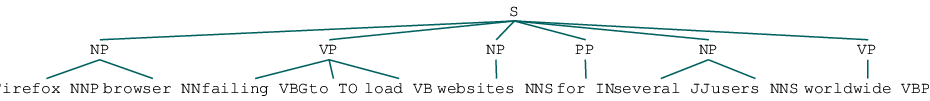

In [35]:
display(chunk_tree)

## Constituency Parsing

In [36]:
scp  =  StanfordParser(path_to_jar='stanford_parser/stanford-parser.jar',
                      path_to_models_jar='stanford_parser/stanford-parser-3.5.2-models.jar')

result = list(scp.raw_parse(sentence))
print(result[0])

<ipython-input-36-75ce5d2602db>:1: DeprecationWarning: The StanfordParser will be deprecated
Please use nltk.parse.corenlp.CoreNLPParser instead.
  scp  =  StanfordParser(path_to_jar='stanford_parser/stanford-parser.jar',


(ROOT
  (S
    (NP (NNP Firefox))
    (VP
      (NN browser)
      (S
        (VP
          (VBG failing)
          (S
            (VP
              (TO to)
              (VP
                (VB load)
                (NP
                  (NP (NNS websites))
                  (PP (IN for) (NP (JJ several) (NNS users))))
                (ADVP (RB worldwide))))))))))


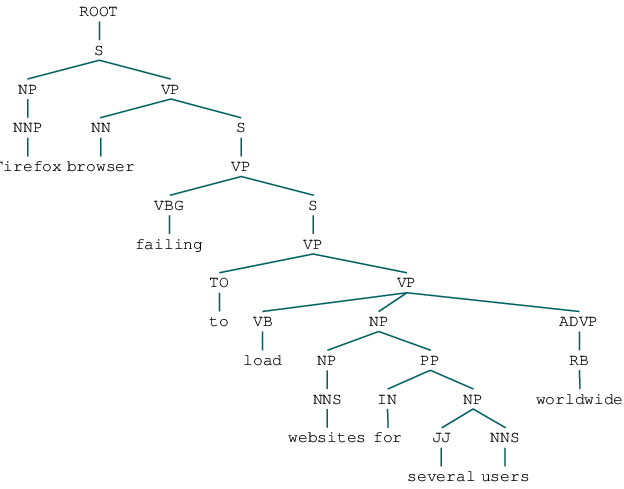

In [37]:
display(result[0])
#Constituency parsed news headline

## Dependency Parsing

#### Using the SpaCy Stanford Parser

In [38]:
dependency_pattern = '{left}<---{word}[{w_type}]--->{right}\n--------'
for token in sentence_nlp:
    print(dependency_pattern.format(word=token.orth_, 
                                  w_type=token.dep_,
                                  left=[t.orth_ 
                                            for t 
                                            in token.lefts],
                                  right=[t.orth_ 
                                             for t 
                                             in token.rights]))

[]<---Firefox[amod]--->[]
--------
['Firefox']<---browser[nsubj]--->[]
--------
['browser']<---failing[ROOT]--->['load']
--------
[]<---to[aux]--->[]
--------
['to']<---load[xcomp]--->['websites', 'for', 'worldwide']
--------
[]<---websites[dobj]--->[]
--------
[]<---for[prep]--->['users']
--------
[]<---several[amod]--->[]
--------
['several']<---users[pobj]--->[]
--------
[]<---worldwide[advmod]--->[]
--------


In [39]:
displacy.render(sentence_nlp, jupyter=True, options={'distance':100,
                                                     'arrow_stroke':2,
                                                    'arrow_width':8})
# News Headline dependency tree from SpaCy

#### Using the ntlk stanford parser

<ipython-input-42-fa36693e8569>:1: DeprecationWarning: The StanfordDependencyParser will be deprecated
Please use nltk.parse.corenlp.CoreNLPDependencyParser instead.
  sdp = StanfordDependencyParser(path_to_jar='stanford_parser/stanford-parser.jar',


(browser
  Firefox
  (failing (load to (websites (users for several)) worldwide)))


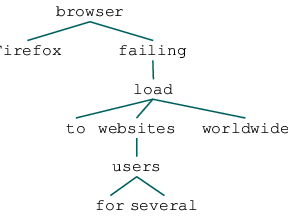

In [42]:
sdp = StanfordDependencyParser(path_to_jar='stanford_parser/stanford-parser.jar',
                              path_to_models_jar='stanford_parser/stanford-parser-3.5.2-models.jar')

result = list(sdp.raw_parse(sentence))

# print to dependency tree

dep_tree = [parse.tree() for parse in result][0]
print(dep_tree)

# visualize raw dependency  tree

display(dep_tree)

# visualize annoted dependency tree

dep_tree_dot_repr = [parse for parse in result][0].to_dot()
source = Source(dep_tree_dot_repr, filename="dep_tree",format="png")


## Named Entity Recognition


In [43]:
sentence = str(news_df.iloc[1].full_text)
sentence_nlp = nlp(sentence)

# print named entities in article
print([(word, word.ent_type_) for word in sentence_nlp if word.ent_type_])

# visualize named entities
displacy.render(sentence_nlp, style='ent', jupyter=True)

[(Twitter, 'PRODUCT'), (Thursday, 'DATE'), (Firefox, 'ORG'), (HTTP3, 'NORP'), (one, 'CARDINAL')]


In [44]:
named_entities = []
for sentence in corpus:
    temp_entity_name = ''
    temp_named_entity = None
    sentence = nlp(sentence)
    for word in sentence:
        term = word.text 
        tag = word.ent_type_
        if tag:
            temp_entity_name = ' '.join([temp_entity_name, term]).strip()
            temp_named_entity = (temp_entity_name, tag)
        else:
            if temp_named_entity:
                named_entities.append(temp_named_entity)
                temp_entity_name = ''
                temp_named_entity = None

entity_frame = pd.DataFrame(named_entities, 
                            columns=['Entity Name', 'Entity Type'])

In [45]:
# get the top named entities
top_entities = (entity_frame.groupby(by=['Entity Name', 'Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.T.iloc[:,:15]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Entity Name,India,South Africa,three,first,US,one,Russia,YouTube,Pakistan,Omicron,UK,Bill Gates,Friday,Sri Lanka,Infosys
Entity Type,GPE,GPE,CARDINAL,ORDINAL,GPE,CARDINAL,GPE,ORG,GPE,ORG,GPE,PERSON,DATE,GPE,ORG
Frequency,24,17,8,8,7,7,7,6,6,6,5,5,5,5,5


In [46]:
# get the top named entity types
top_entities = (entity_frame.groupby(by=['Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.T.iloc[:,:15]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Entity Type,GPE,PERSON,ORG,CARDINAL,DATE,NORP,ORDINAL,MONEY,PERCENT,LOC,PRODUCT,TIME,WORK_OF_ART,QUANTITY,EVENT
Frequency,127,116,100,82,82,41,28,18,9,7,7,6,3,2,1


In [47]:
# initialize NER tagger
sn = StanfordNERTagger('stanford_ner/classifiers/english.all.3class.distsim.crf.ser.gz',
                       path_to_jar='stanford_ner/stanford-ner.jar')

# tag named entities
ner_tagged_sentences = [sn.tag(sent.split()) for sent in corpus]

# extract all named entities
named_entities = []
for sentence in ner_tagged_sentences:
    temp_entity_name = ''
    temp_named_entity = None
    for term, tag in sentence:
        if tag != 'O':
            temp_entity_name = ' '.join([temp_entity_name, term]).strip()
            temp_named_entity = (temp_entity_name, tag)
        else:
            if temp_named_entity:
                named_entities.append(temp_named_entity)
                temp_entity_name = ''
                temp_named_entity = None

#named_entities = list(set(named_entities))
entity_frame = pd.DataFrame(named_entities, 
                            columns=['Entity Name', 'Entity Type'])
                            

# view top entities and types
top_entities = (entity_frame.groupby(by=['Entity Name', 'Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.head(15)

,Entity Name,Entity Type,Frequency
0,India,LOCATION,24
1,South Africa,LOCATION,20
2,Google,ORGANIZATION,8
3,UK,LOCATION,8
4,US,LOCATION,6
5,YouTube,ORGANIZATION,6
6,Pakistan,LOCATION,6
7,Russia,LOCATION,6
8,Infosys,ORGANIZATION,6
9,Sri Lanka,LOCATION,5


In [ ]:
# view top entity types
top_entities = (entity_frame.groupby(by=['Entity Type'])
                           .size()
                           .sort_values(ascending=False)
                           .reset_index().rename(columns={0 : 'Frequency'}))
top_entities.head()

## Sentiment Analysis using AFINN lexicon

In [93]:
from afinn import Afinn

af = Afinn()

In [104]:
sentiment_scores = [af.score(article) for article in corpus]
sentiment_category = ['positive' if score > 0 
                          else 'negative' if score < 0 
                              else 'neutral' 
                                  for score in sentiment_scores]

In [95]:
df = pd.DataFrame([list(news_df['news_category']), sentiment_scores, sentiment_category]).T
df.columns = ['news_category', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['news_category']).describe()

sentiment_score                                                
                        count      mean       std   min   25%  50%  75%   max
news_category                                                                
sports                   25.0  3.400000  8.067424 -11.0   0.0  4.0  9.0  18.0
technology               25.0 -1.800000  6.487167 -14.0  -7.0  0.0  2.0  10.0
world                    24.0 -5.708333  6.785401 -22.0 -11.0 -6.0 -1.0   7.0

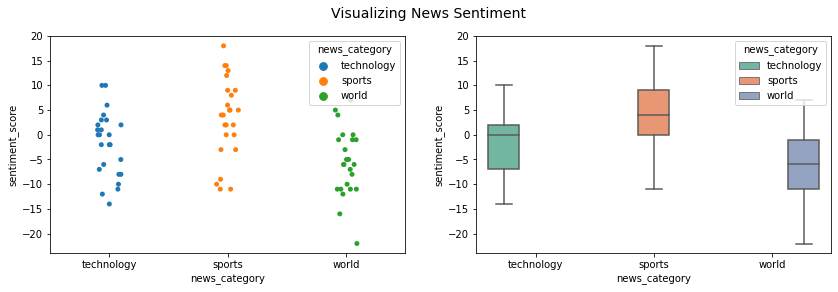

In [96]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
sp = sns.stripplot(x='news_category', y="sentiment_score", 
                   hue='news_category', data=df, ax=ax1)
bp = sns.boxplot(x='news_category', y="sentiment_score", 
                 hue='news_category', data=df, palette="Set2", ax=ax2)
t = f.suptitle('Visualizing News Sentiment', fontsize=14)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


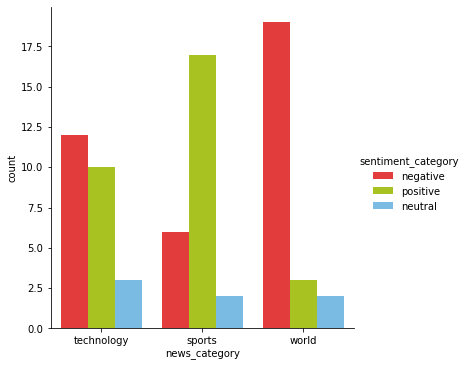

In [97]:
fc = sns.factorplot(x="news_category", hue="sentiment_category", 
                    data=df, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"})

In [99]:
pos_idx = df[(df.news_category=='technology') & (df.sentiment_score == 10)].index[0]
neg_idx = df[(df.news_category=='technology') & (df.sentiment_score == -14)].index[0]

print('Most Negative Tech News Article:', news_df.iloc[neg_idx][['news_article']][0])
print()
print('Most Positive Tech News Article:', news_df.iloc[pos_idx][['news_article']][0])

Most Negative Tech News Article: Meta is facing a £2.3 billion ($3.2 billion) class action lawsuit that claims 44 million Facebook users in the UK had their personal data exploited after signing up to the social networking platform. The lawsuit argues that Meta broke the Competition Act 1998. Facebook set an "unfair price" for UK users for granting access to its platform, claims the lawsuit.

Most Positive Tech News Article: A non-profit council is offering $10,000 in bitcoin and free bikes to tech workers if they relocate to Northwest Arkansas in US. "This offer embraces the growing trend toward the use of cryptocurrency as a payment option by employers, but also helps increase our pipeline of talent," Northwest Arkansas Council CEO said. Northwest Arkansas reportedly has over 10,000 job openings.


In [100]:
pos_idx = df[(df.news_category=='world') & (df.sentiment_score == 7)].index[0]
neg_idx = df[(df.news_category=='world') & (df.sentiment_score == -22)].index[0]

print('Most Negative World News Article:', news_df.iloc[neg_idx][['news_article']][0])
print()
print('Most Positive World News Article:', news_df.iloc[pos_idx][['news_article']][0])

Most Negative World News Article: A 20-year-old woman in the UK, who created 30 fake Instagram profiles and sent herself threats in an attempt to frame her ex-boyfriend, has been jailed for 10 months. She had given police statements claiming that he threatened to stab her. Her ex-boyfriend was arrested six times, charged with assault and given a home curfew order with an electronic tag.

Most Positive World News Article: Swedish PM Magdalena Andersson has tested positive for COVID-19, her spokesperson said on Friday. "She is following the current recommendations and will perform her duties from home. The PM is feeling well, given the situation," the spokesperson added. Sweden's King Carl XVI Gustaf and Queen Silvia, fully vaccinated with three injections, had tested positive for COVID-19 last week. 


In [101]:
from textblob import TextBlob

# compute sentiment scores (polarity) and labels
sentiment_scores_tb = [round(TextBlob(article).sentiment.polarity, 3) for article in news_df['clean_text']]
sentiment_category_tb = ['positive' if score > 0 
                             else 'negative' if score < 0 
                                 else 'neutral' 
                                     for score in sentiment_scores_tb]


# sentiment statistics per news category
df = pd.DataFrame([list(news_df['news_category']), sentiment_scores_tb, sentiment_category_tb]).T
df.columns = ['news_category', 'sentiment_score', 'sentiment_category']
df['sentiment_score'] = df.sentiment_score.astype('float')
df.groupby(by=['news_category']).describe()

sentiment_score                                              \
                        count      mean       std    min      25%     50%   
news_category                                                               
sports                   25.0  0.256000  0.180306 -0.075  0.15000  0.2470   
technology               25.0  0.025120  0.198604 -0.333 -0.05800  0.0150   
world                    24.0 -0.003375  0.152839 -0.333 -0.08025  0.0285   

                              
                  75%    max  
news_category                 
sports         0.3900  0.633  
technology     0.0860  0.667  
world          0.0805  0.331

/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


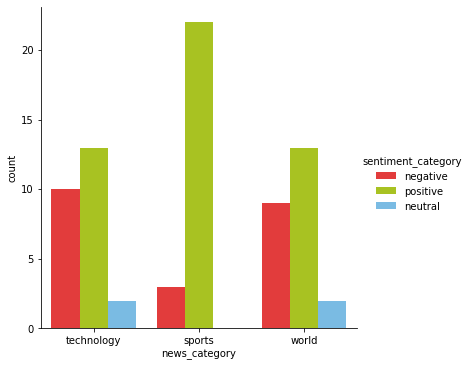

In [89]:
fc = sns.factorplot(x="news_category", hue="sentiment_category", 
                    data=df, kind="count", 
                    palette={"negative": "#FE2020", 
                             "positive": "#BADD07", 
                             "neutral": "#68BFF5"})

In [102]:
pos_idx = df[(df.news_category=='world') & (df.sentiment_score == 0.331)].index[0]
neg_idx = df[(df.news_category=='world') & (df.sentiment_score == -0.333)].index[0]

print('Most Negative World News Article:', news_df.iloc[neg_idx][['news_article']][0])
print()
print('Most Positive World News Article:', news_df.iloc[pos_idx][['news_article']][0])

Most Negative World News Article: An earthquake of magnitude 6.6 shook parts of Indonesia including capital Jakarta on Friday. No casualties or serious damage were reported and the Met agency ruled out the danger of Tsunami. As per the US Geological Survey, the epicentre of the quake was located in the Indian Ocean about 88 km southwest of the Labuan town.

Most Positive World News Article: The Norwegian Nobel Committee condemned Nobel Peace Prize winner Ethiopian Prime Minister Abiy Ahmed over the ongoing war-like situation and humanitarian crisis in the country's Tigray region. "Abiy Ahmed has a special responsibility to end the conflict and contribute to peace," the Committee said. Notably, the Ethiopian government allowed Eritrean forces to enter Tigray amid political tensions.


In [103]:
import model_evaluation_utils as meu
meu.display_confusion_matrix_pretty(true_labels=sentiment_category, 
                                    predicted_labels=sentiment_category_tb, 
                                    classes=['negative', 'neutral', 'positive'])

TypeError: __new__() got an unexpected keyword argument 'labels'